In [41]:
"""
    Machine Learning Project
    Implementation for Metric Learning using Siamese Network (Triplet Loss)
"""
# Importing Libraries
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

from pathlib import Path

In [42]:
# Checking Versions of Libraries
print("TensorFlow: {}".format(tf.__version__))
print("matplotlib: {}".format(matplotlib.__version__))
print("Numpy: {}".format(np.version.version))
print("Built With Cuda: {}".format(tf.test.is_built_with_cuda()))
print("TensorFlow GPU: {}".format(tf.config.list_physical_devices('GPU')))

TensorFlow: 2.10.1
matplotlib: 3.8.1
Numpy: 1.26.2
Built With Cuda: True
TensorFlow GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [43]:
# Configure the Image shape and Batch Size
IMAGE_SHAPE = (200, 200)
BATCH_SIZE = 32

In [44]:
# Set Up Paths for Data Directories
main_dir = "C:/Users/liang/Downloads/COS30082/"
anchor_dir = Path(os.path.join(main_dir, "siamese_dir/anchor/"))
positive_dir = Path(os.path.join(main_dir, "siamese_dir/positive/"))

In [45]:
# Preprocessing Image Data
def preprocess_image(image_path):
    image_string = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, IMAGE_SHAPE)
    return image

# Preprocessing Triplet Data
def preprocess_triplets(anchor, positive, negative):
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [46]:
# Sort the images accordingly to make sure that
# both anchor and positive are in the same order
anchor_images = sorted(
    [str(anchor_dir / f) for f in os.listdir(anchor_dir)]
)

positive_images = sorted(
    [str(positive_dir / f) for f in os.listdir(positive_dir)]
)

# Total number of images
image_count = len(anchor_images)

# Create dataset of anchors and positives
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

# Random shuffle the anchor images and positive images
rnd = np.random.RandomState(seed=42)
rnd.shuffle(anchor_images)
rnd.shuffle(positive_images)

negative_images = anchor_images + positive_images
np.random.RandomState(seed=32).shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Split the dataset into train and validation datasets
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

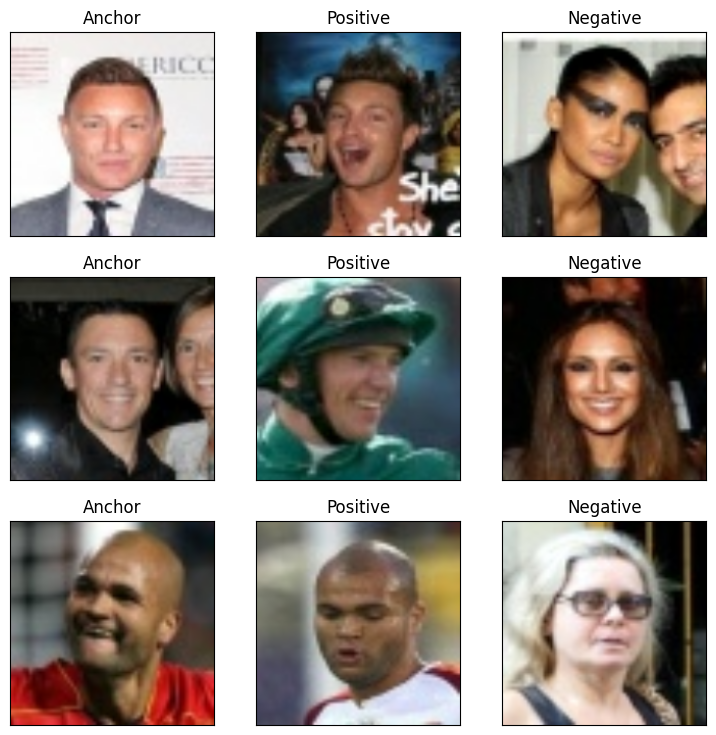

In [47]:
# Visualize the anchor, positive, and negative images
def visualize(anchor, positive, negative):
    def show(ax, image, label):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title(label)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    labels = ['Anchor', 'Positive', 'Negative']
    for i in range(3):
        show(axs[i, 0], anchor[i], labels[0])
        show(axs[i, 1], positive[i], labels[1])
        show(axs[i, 2], negative[i], labels[2])

# Visualize the 3 anchor, positive, and negative images
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])


In [48]:
# Load the base model (ResNet50)
base_model = tf.keras.applications.ResNet50(
    weights="imagenet", 
    input_shape=IMAGE_SHAPE + (3,), 
    include_top=False
)

In [49]:
# Display the base model architecture
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [50]:
# Build the model
x = tf.keras.layers.Flatten()(base_model.output)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(256)(x)

# Create embedding model
embedding = tf.keras.Model(base_model.input, output, name="Embedding")

# Set all base model layers to be non-trainable
trainable = False
for layer in base_model.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [51]:
embedding.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [52]:
# Create the layer to compute the distance between anchor and positive embedding VS anchor and negative embedding
class DistanceLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)

# Create inputs for anchor, positive and negative 
anchor_input = tf.keras.layers.Input(name="anchor", shape=IMAGE_SHAPE + (3,))
positive_input = tf.keras.layers.Input(name="positive", shape=IMAGE_SHAPE + (3,))
negative_input = tf.keras.layers.Input(name="negative", shape=IMAGE_SHAPE + (3,))

# Outputs containing the distances from the anchor to the positive and negative images
distances = DistanceLayer()(
    embedding(tf.keras.applications.resnet50.preprocess_input(anchor_input)),
    embedding(tf.keras.applications.resnet50.preprocess_input(positive_input)),
    embedding(tf.keras.applications.resnet50.preprocess_input(negative_input)),
)

# Define the siamese network
siamese_network = tf.keras.Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [53]:
# Create the Siamese Network model
# Computes the triplet loss using the three embeddings produced by the Siamese Network
class SiameseModel(tf.keras.Model):
    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [54]:
# Define the model
siamese_model = SiameseModel(siamese_network)

In [55]:
# def compilefit():
#     # Training history
#     history_callback = tf.keras.callbacks.History()
#     # Compile the model
#     siamese_model.compile(optimizer=tf.keras.optimizers.Adam(0.0001))
#     # Train the model
#     siamese_model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[history_callback])

#     return siamese_model

# # Compile and fit the model
# siamese_model = compilefit()
# history = siamese_model.history.history

In [56]:
# # Save the weights of the siamese model
# def save(SiameseModel, checkpoint_name):
#     SiameseModel.save_weights(Path(os.path.join("./checkpoints/", checkpoint_name)))

# # Save the model
# checkpoint_name = input("Checkpoint Name: ")
# save(siamese_model, checkpoint_name)

In [57]:
# Load the weights of the siamese model
def load(SiameseModel, checkpoint_name):
    SiameseModel.load_weights(Path(os.path.join('./checkpoints/', checkpoint_name)))

# Load the model
checkpoint_name = input("Checkpoint Name: ")
load(siamese_model, checkpoint_name)

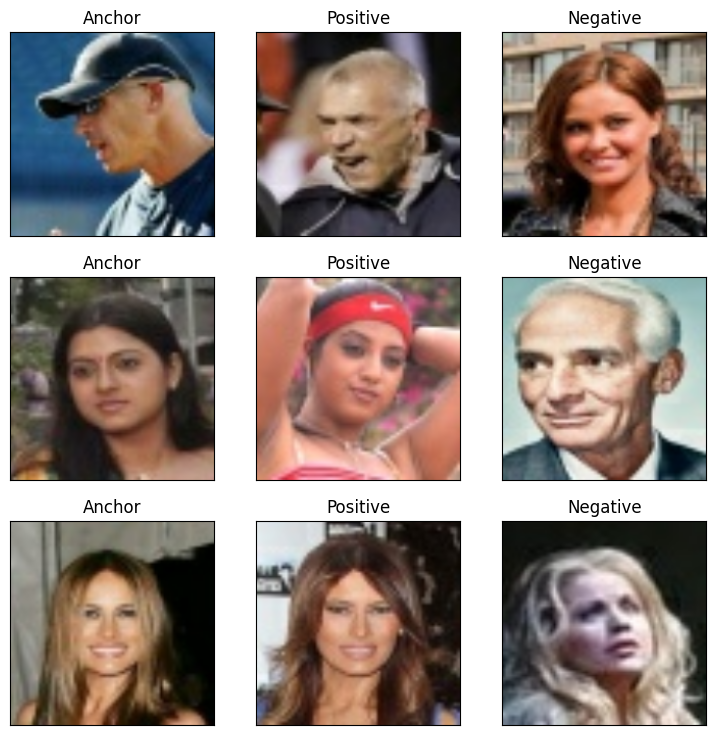

In [58]:
# Take a sample from the dataset to check similarity
sample = next(iter(train_dataset))
visualize(*sample)

anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(tf.keras.applications.resnet50.preprocess_input(anchor)),
    embedding(tf.keras.applications.resnet50.preprocess_input(positive)),
    embedding(tf.keras.applications.resnet50.preprocess_input(negative)),
)

In [59]:
# Evaluation Metrics - Cosine Similarity
cosine_similarity = tf.keras.metrics.CosineSimilarity()

# Positive Similarity 
positive_similarity = cosine_similarity(anchor_embedding, positive_embedding)
print("Positive similarity:", positive_similarity.numpy())

# Negative Similarity 
negative_similarity = cosine_similarity(anchor_embedding, negative_embedding)
print("Negative similarity", negative_similarity.numpy())

Positive similarity: 0.9998891
Negative similarity 0.99982977


In [60]:
# Evaluation Metrics - Euclidean Distance

# Positive Euclidean Distance
positive_euclidean_distance = np.linalg.norm(anchor_embedding - positive_embedding)
print("Positive euclidean distance:", positive_euclidean_distance)

# Negative Euclidean Distance
negative_euclidean_distance = np.linalg.norm(anchor_embedding - negative_embedding)
print("Negative euclidean distance:", negative_euclidean_distance)

Positive euclidean distance: 4.0105815
Negative euclidean distance: 5.7578297


In [61]:
verification_data_file = Path(os.path.join(main_dir, "verification_pairs_val.txt"))

correct_predictions = 0
total_pairs = 0

trial1_embeddings = []
trial2_embeddings = []
negative_embeddings = []
labels = []

# Read and preprocess all pairs
with open(verification_data_file) as f:
    verification_lines = f.readlines()[100:200]

for line in verification_lines:
    trial1, trial2, label = line.split()

    trial1 = preprocess_image(trial1)
    trial2 = preprocess_image(trial2)

    trial1_embeddings.append(embedding(tf.keras.applications.resnet50.preprocess_input(trial1[None, ...])))
    trial2_embeddings.append(embedding(tf.keras.applications.resnet50.preprocess_input(trial2[None, ...])))

    labels.append(int(label))

print("Preprocessing completed for all pairs.")

# Define negative embeddings as the shuffled trial2 embeddings
negative_embeddings = trial2_embeddings.copy()
np.random.shuffle(negative_embeddings)

# Calculate Euclidean distances for all pairs
trial1_embeddings = np.vstack(trial1_embeddings)
trial2_embeddings = np.vstack(trial2_embeddings)
negative_embeddings = np.vstack(negative_embeddings)

positive_distances_test = np.linalg.norm(trial1_embeddings - trial2_embeddings, axis=1)
negative_distances_test = np.linalg.norm(trial1_embeddings - negative_embeddings, axis=1)

print("Euclidean distances calculated for all pairs.")

# Apply threshold and predict for all pairs
predicted_labels = (positive_distances_test < negative_distances_test).astype(int)

print("Predictions made for all pairs.")

# Check correctness and calculate accuracy
correct_predictions = np.sum(labels == predicted_labels)
total_pairs = len(labels)
accuracy = correct_predictions / total_pairs

print(f"Accuracy: {accuracy:.2%}")

Preprocessing completed for all pairs.
Euclidean distances calculated for all pairs.
Predictions made for all pairs.
Accuracy: 64.00%


In [62]:
import numpy as np

# Assuming positive distances should have higher values than negative distances
y_true = np.ones(len(positive_distances_test))
y_scores = np.concatenate((negative_distances_test, positive_distances_test))

# Create true labels (1 for positive distances, 0 for negative distances)
true_labels = np.concatenate((np.zeros(len(negative_distances_test)), np.ones(len(positive_distances_test))))

# Combine true labels and scores into a single array
combined = np.column_stack((true_labels, y_scores))

# Sort the combined array based on the scores in descending order
sorted_combined = combined[np.argsort(combined[:, 1])[::-1]]

# Initialize variables for ROC curve
true_positive_count = 0
false_positive_count = 0
roc_points = []

# Calculate ROC curve points
for label, score in sorted_combined:
    if label == 1:
        true_positive_count += 1
    else:
        false_positive_count += 1
    sensitivity = true_positive_count / len(positive_distances_test)
    specificity = 1 - false_positive_count / len(negative_distances_test)
    roc_points.append((1 - specificity, sensitivity))

# Calculate the area under the ROC curve (AUC-ROC)
roc_auc = np.trapz([point[1] for point in roc_points], [point[0] for point in roc_points])

print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.43979999999999997


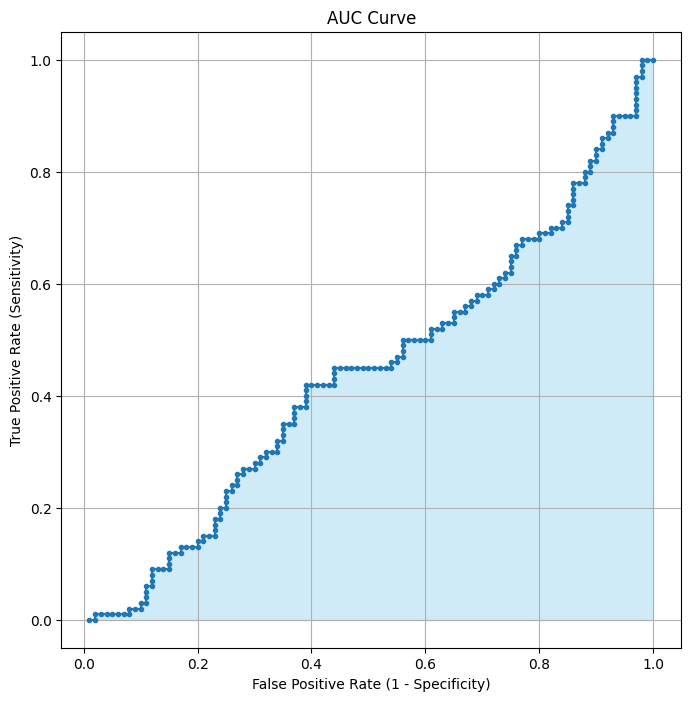

In [63]:
# Visualize AUC curve
plt.figure(figsize=(8, 8))
plt.plot([point[0] for point in roc_points], [point[1] for point in roc_points], marker='.')
plt.fill_between([point[0] for point in roc_points], 0, [point[1] for point in roc_points], color='skyblue', alpha=0.4)
plt.title('AUC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.show()

In [64]:
verification_data_file = Path(os.path.join(main_dir, "verification_pairs_val.txt"))

correct_predictions = 0
total_pairs = 0

trial1_embeddings = []
trial2_embeddings = []
negative_embeddings = []
labels = []

# Read and preprocess all pairs
with open(verification_data_file) as f:
    verification_lines = f.readlines()[100:200]

for line in verification_lines:
    trial1, trial2, label = line.split()

    trial1 = preprocess_image(trial1)
    trial2 = preprocess_image(trial2)

    trial1_embeddings.append(embedding(tf.keras.applications.resnet50.preprocess_input(trial1[None, ...])))
    trial2_embeddings.append(embedding(tf.keras.applications.resnet50.preprocess_input(trial2[None, ...])))

    labels.append(int(label))

print("Preprocessing completed for all pairs.")

# Define negative embeddings as the shuffled trial2 embeddings
negative_embeddings = trial2_embeddings.copy()
np.random.shuffle(negative_embeddings)

# Calculate Euclidean distances for all pairs
trial1_embeddings = np.vstack(trial1_embeddings)
trial2_embeddings = np.vstack(trial2_embeddings)
negative_embeddings = np.vstack(negative_embeddings)

# Calculate Cosine similarities for all pairs
positive_similarities_test = cosine_similarity(trial1_embeddings, trial2_embeddings)
negative_similarities_test = cosine_similarity(trial1_embeddings, negative_embeddings)

print("Cosine similarities calculated for all pairs.")

# Apply threshold and predict for all pairs
positive_similarities_test_np = np.array(positive_similarities_test)
negative_similarities_test_np = np.array(negative_similarities_test)

predicted_labels = (positive_similarities_test_np > negative_similarities_test_np).astype(int)

print("Predictions made for all pairs.")

# Check correctness and calculate accuracy
correct_predictions = np.sum(labels == predicted_labels)
total_pairs = len(labels)
accuracy = correct_predictions / total_pairs

print(f"Accuracy: {accuracy:.2%}")

Preprocessing completed for all pairs.
Cosine similarities calculated for all pairs.
Predictions made for all pairs.
Accuracy: 51.00%


In [65]:
import numpy as np

# Assuming positive and negative similarities are calculated
# positive_similarities_test and negative_similarities_test

# Ensure that the arrays are 1-dimensional
positive_similarities_test_np = np.atleast_1d(np.squeeze(positive_similarities_test_np))
negative_similarities_test_np = np.atleast_1d(np.squeeze(negative_similarities_test_np))

# Concatenate positive and negative similarities and corresponding labels
all_similarities = np.concatenate([positive_similarities_test_np, negative_similarities_test_np])
all_labels = np.concatenate([np.ones_like(positive_similarities_test_np), np.zeros_like(negative_similarities_test_np)])

# Sort the similarities and corresponding labels in descending order
sorted_indices = np.argsort(all_similarities)[::-1]
sorted_labels = all_labels[sorted_indices]

# Calculate true positive rate (TPR) and false positive rate (FPR)
tp = np.cumsum(sorted_labels)
fp = np.cumsum(1 - sorted_labels)
tn = np.sum(1 - sorted_labels)
fn = np.sum(sorted_labels)

tpr = tp / (tp + fn)
fpr = fp / (fp + tn)

# Calculate ROC-AUC by approximating the area under the curve using the trapezoidal rule
roc_auc = np.trapz(tpr, fpr)

print(f"ROC-AUC Score: {roc_auc:.2f}")


ROC-AUC Score: 0.25


In [85]:
# register new face
import json
import numpy as np

# Assuming you have an existing JSON file with embeddings
existing_file_path = "newuser.json"# 

if not os.path.exists(existing_file_path):
    with open(existing_file_path, "w") as f:
        json.dump([], f)

# Load existing embeddings from the file
with open(existing_file_path, "r") as f:
    existing_embeddings = json.load(f)

# Generate the embedding for the new user
new_user_embedding = embedding(np.array([preprocess_image("C:/Users/liang/Downloads/COS30082/john.jpg")]))
new_user_embedding = new_user_embedding.numpy()
new_user_embedding = new_user_embedding.tolist()

# Append the new user embedding to the existing embeddings
existing_embeddings.append(new_user_embedding)

# Save the updated embeddings back to the JSON file
with open(existing_file_path, "w") as f:
    json.dump(existing_embeddings, f)
